- Aution Software CodeAThon Link: https://github.com/AuctionSoftwareCodeAThon/2024
- Emotions: https://www.extremetech.com/extreme/173748-human-emotions-mapped-for-the-first-time-shows-where-we-feel-love-fear-and-shame

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from importlib import reload

from tqdm import tqdm

import utils

import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

## Load data and preprocess lyrics

In [250]:
SPOTIFY_MILLION_SONG_DATASET = "Spotify Million Song Dataset_exported.csv"
df = pd.read_csv(SPOTIFY_MILLION_SONG_DATASET)

In [251]:
%%time
Processor = utils.PreprocessorAndFeatureGenerator(df=df)

texts_filtered = Processor.df.text_filtered.to_list()

Processor.generate_tfidf_dict(texts=texts_filtered)

tfidf_np_matrix = Processor.tfidf_to_matrix(tfidf_matrix=Processor.TFIDF_DICT, texts=texts_filtered)

57650it [00:06, 8857.17it/s] 
100%|█████████████████████████████████████████████████████████████████████████| 57650/57650 [00:01<00:00, 46151.06it/s]


CPU times: total: 11.9 s
Wall time: 22.9 s


## K-Means Clustering

In [246]:
reload(utils)
Classifier = utils.MoodClassifier(k=7, max_iters=5)

In [252]:
clusters, centroids = Classifier.kmeans(X=tfidf_np_matrix, seed=6)

d = {}
for num in clusters:
    d[num] = d.get(num, 0) + 1
d

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


{2: 37585, 1: 3287, 3: 3104, 0: 4655, 6: 1411, 4: 5120, 5: 2488}

In [266]:
df_raw = pd.read_csv(SPOTIFY_MILLION_SONG_DATASET)
df_raw['cluster'] = clusters

In [267]:
df_raw.to_csv("clustered-lyrics.csv", index=False)

In [268]:
df_raw.cluster.value_counts()

cluster
2    37585
4     5120
0     4655
1     3287
3     3104
5     2488
6     1411
Name: count, dtype: int64

## Naming Clusters

In [271]:
cluster_to_mood_map = {
    0: "FEAR",
    1: "SADNESS",
    2: "HAPPINESS",
    3: "DISGUST",
    4: "ANGER",
    5: "SURPRISE",
    6: "NEUTRAL"
}

In [281]:
summary = {}

for key, count in d.items():
    summary[cluster_to_mood_map[key]] = df_raw.cluster.value_counts()[key]


In [293]:
pd.DataFrame(list(summary.values()), list(summary.keys()), columns=['count'])

,count
HAPPINESS,37585
SADNESS,3287
DISGUST,3104
FEAR,4655
NEUTRAL,1411
ANGER,5120
SURPRISE,2488


## Classifying a new song

In [256]:
new_song_lyric = df_raw.sample()['text'].values[0]
print(new_song_lyric[:100])

processed_song_lyrics = [Processor.preprocess_lyrics(new_song_lyric)]

Its always fair weather,  
When hep cats get together!  
And every time they meet,  
Heres the way y


In [258]:
test_tfidf_dict = Processor.generate_tfidf_dict(texts=processed_song_lyrics, mode="inference")
test_tfidf_np_matrix = Processor.tfidf_to_matrix(tfidf_matrix=test_tfidf_dict, texts=processed_song_lyrics)

1it [00:00, 351.84it/s]


In [273]:
cluster_to_mood_map[Classifier.classify(batch=test_tfidf_np_matrix)[0]]

'HAPPINESS'

In [161]:
lengths = df.text.apply(lambda x: len(x))

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,100%,max
text,57650.0,111.809315,59.929734,21.0,48.0,55.0,72.0,98.0,133.0,181.0,231.0,688.0,688.0


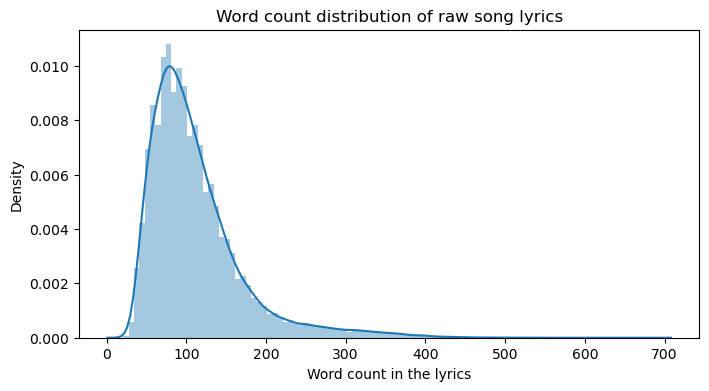

In [163]:
display(pd.DataFrame(lengths.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])).T)

plt.figure(figsize=(8,4))
sns.distplot(lengths, bins=100)
plt.title("Word count distribution of raw song lyrics")
plt.xlabel("Word count in the lyrics")
plt.show()

QUANTILE_NINETY = lengths.quantile(0.9)

In [164]:
CORPUS = dict()

In [167]:
for index in range(len(df)):
    text = df.iloc[index]['text']
    for token in text:
        CORPUS[token] = CORPUS.get(token, 0) + 1

In [168]:
sorted_frequencies = sorted(CORPUS.items(), key=lambda item: item[1], reverse=True)

In [171]:
len(sorted_frequencies)

149365

In [172]:
len(df)

57650